# Can we beat Welch's t-test?

The current version of this script is super-stupid. But to do any interesting research, you have to plant
a few small acorns, and this is the smallest of acorns.

Suppose you have to evaluate NUMBER_OF_EXPERIMENTS very small experiments. By a weird
coincidence, they all have the same number of participants. There are CONTROL_GROUP_SIZE patients
getting a placebo, and EXPERIMENT_GROUP_SIZE getting a drug.

Unfortunately approximately PROPORTION_OF_EXPERIMENTS_THAT_DO_NOTHING of those drugs actually have no effect either.

You want to create a classifier to determine whether or not the experimental drug worked.

Also, amazingly, the control group and the experimental group metrics are normally distributed. 

You don't know the population mean or standard deviation: you don't know it for the control group 
and you don't know it for the experimental group.

You do know that the control group's standard deviation is somewhere between 
CONTROL_POPULATION_STDDEV_LOW and CONTROL_POPULATION_STDDEV_HIGH. You know this
because you know something about your field, it would be impossible for the standard deviation to be
outside of these bounds.

Obviously, the experiments where the drug is useless the experimental data will have the same mean and standard deviation as the controls.

In the experiments where the drug is useful, they differ. You don't know how much, but you can put some bounds
on it:

- the distribution of data from a successful experimental will have a mean within EXPERIMENTAL_MEAN_RANGE of
  the control group's mean
  
- the standard deviation will be between EXPERIMENTAL_STDDEV_LOW and EXPERIMENTAL_STDDEV_HIGH

-------

Being a well-trained statistician with years of experience, you use Welch's t-test.

Your offsider is a clueless data scientist whose sole training consisted of reading the sklearn documentation.

Who wins?

--------
It depends on PROPORTION_OF_EXPERIMENTS_THAT_DO_NOTHING. If this is very high (e.g. 0.9) then just about
any approach will beat the Welch t-test: giving better accuracy and a lower type 1 error. 1000 data points
and a random forest classifier, a neural network... even nearest neighbours techniques will work.

If it is moderately high (e.g. 0.66) then random forests can usually beat the Welch t-test for accuracy,
and keep the type 1 errors below 0.05 with 1000 data points. With a bit more data (around 10,000) a neural
network can do the same. With 1,000,000 data points the poly-linear approach can do it.

If it is low (e.g. 0.1) then most algorithms can beat Welch on accuracy, but keeping the type 1 errors
below 0.05 becomes very difficult.

**Thoughts**: if we have a prior on the likelihood of success of the experiment, we can make a better
discriminator. So the right thing I need to compare against is some sort of pseudo-Bayesian version
of the Welch t-test.

In [1]:
CONTROL_GROUP_SIZE=4
EXPERIMENT_GROUP_SIZE=3
#PROPORTION_OF_EXPERIMENTS_THAT_DO_NOTHING=0.66
PROPORTION_OF_EXPERIMENTS_THAT_DO_NOTHING=0.75
#PROPORTION_OF_EXPERIMENTS_THAT_DO_NOTHING=0.9
#PROPORTION_OF_EXPERIMENTS_THAT_DO_NOTHING=0.1

NUMBER_OF_EXPERIMENTS=1000

CONTROL_POPULATION_STDDEV_LOW=1
CONTROL_POPULATION_STDDEV_HIGH=5

EXPERIMENTAL_MEAN_RANGE=10
EXPERIMENTAL_STDDEV_LOW=1
EXPERIMENTAL_STDDEV_HIGH=10

In [2]:
import scipy
import scipy.stats
import collections
import pandas
import numpy
import sklearn.model_selection
import sklearn.svm
import sklearn.dummy
import sklearn.metrics
import sklearn.tree
import sklearn.ensemble
import sklearn.neighbors
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

In [3]:
Experiment = collections.namedtuple("Experiment",
                                    ["ControlLoc", "ControlScale", "ControlValues",
                                     "ObservedControlMean", "ObservedControlStddev",
                                   "ExperimentLoc", "ExperimentScale", "ExperimentValues", 
                                   "ShouldShowResult"])

In [4]:
def generate_experiment():
    null_experiment = scipy.stats.uniform.rvs() <= PROPORTION_OF_EXPERIMENTS_THAT_DO_NOTHING
    # wlog...
    control_loc = 0
    control_scale = scipy.stats.uniform.rvs(loc=CONTROL_POPULATION_STDDEV_LOW,
                                            scale=CONTROL_POPULATION_STDDEV_HIGH-CONTROL_POPULATION_STDDEV_LOW)
    if null_experiment:
        experiment_loc = control_loc
        experiment_scale = control_scale
    else:
        experiment_loc = scipy.stats.uniform.rvs(loc=0, scale=EXPERIMENTAL_MEAN_RANGE)
        experiment_scale = scipy.stats.uniform.rvs(loc=EXPERIMENTAL_STDDEV_LOW, 
                                                   scale=EXPERIMENTAL_STDDEV_HIGH-EXPERIMENTAL_STDDEV_LOW)
    control_values = numpy.sort(scipy.stats.norm.rvs(loc=control_loc, scale=control_scale, size=CONTROL_GROUP_SIZE))
    experiment_values = numpy.sort(scipy.stats.norm.rvs(loc=experiment_loc, scale=experiment_scale, size=EXPERIMENT_GROUP_SIZE))
    return Experiment(ControlLoc=control_loc, 
                      ControlScale=control_scale,
                     ControlValues=control_values,
                      ObservedControlMean=control_values.mean(),
                      ObservedControlStddev=control_values.std(),
                     ExperimentLoc=experiment_loc,
                     ExperimentScale=experiment_scale,
                     ExperimentValues=experiment_values,
                     ShouldShowResult=not(null_experiment))

def generate_experiments(number_of_experiments):
    return [generate_experiment() for n in range(number_of_experiments)]

In [5]:
def create_feature_dataframe(experiments):
    records = []
    for experiment in experiments:
        record = {}
        mean = experiment.ObservedControlMean
        s = experiment.ObservedControlStddev
        # We will need to shift everything down by mean, and divide by s
        for i in range(CONTROL_GROUP_SIZE):
            record[f"c{i}"] = (experiment.ControlValues[i] - mean) / s
        for i in range(EXPERIMENT_GROUP_SIZE):
            record[f"x{i}"] = (experiment.ExperimentValues[i] - mean) / s
        records.append(record)
    raw_data_dataframe = pandas.DataFrame.from_records(records)
    for i in range(EXPERIMENT_GROUP_SIZE):
        for j in range(CONTROL_GROUP_SIZE):
            raw_data_dataframe[f"t_c{j}x{i}"] = raw_data_dataframe[f"c{j}"] - raw_data_dataframe[f"x{i}"]
    return raw_data_dataframe

def create_target_series(experiments):
    return pandas.Series([x.ShouldShowResult for x in experiments])

In [6]:
experiments = generate_experiments(NUMBER_OF_EXPERIMENTS)
feature_dataframe = create_feature_dataframe(experiments)
feature_dataframe

,c0,c1,c2,c3,x0,x1,x2,t_c0x0,t_c1x0,t_c2x0,t_c3x0,t_c0x1,t_c1x1,t_c2x1,t_c3x1,t_c0x2,t_c1x2,t_c2x2,t_c3x2
0,-0.691839,-0.596464,-0.436526,1.724829,-2.716865,1.001952,1.970153,2.025025,2.120400,2.280339,4.441693,-1.693791,-1.598416,-1.438478,0.722877,-2.661992,-2.566617,-2.406679,-0.245324
1,-1.503181,-0.009991,0.210919,1.302252,-1.053387,-0.232376,0.231981,-0.449794,1.043396,1.264306,2.355639,-1.270805,0.222385,0.443295,1.534628,-1.735162,-0.241972,-0.021061,1.070271
2,-1.494451,0.062556,0.108683,1.323212,0.063866,0.157861,0.281101,-1.558317,-0.001310,0.044817,1.259347,-1.652312,-0.095305,-0.049178,1.165351,-1.775552,-0.218545,-0.172418,1.042112
3,-1.370092,-0.538885,0.882534,1.026443,-2.463699,-1.805063,-0.894816,1.093607,1.924814,3.346233,3.490142,0.434971,1.266178,2.687596,2.831506,-0.475275,0.355931,1.777350,1.921260
4,-1.176079,-0.682379,0.468652,1.389806,-0.857129,-0.608565,-0.172936,-0.318951,0.174749,1.325781,2.246935,-0.567514,-0.073814,1.077217,1.998371,-1.003143,-0.509443,0.641589,1.562742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.408009,-0.317933,0.400917,1.325026,1.969687,10.347297,19.125269,-3.377696,-2.287620,-1.568770,-0.644661,-11.755307,-10.665231,-9.946380,-9.022272,-20.533278,-19.443202,-18.724352,-17.800243
996,-1.057065,-0.907721,0.728952,1.235834,-4.658587,-1.766371,1.051346,3.601522,3.750866,5.387539,5.894421,0.709306,0.858650,2.495323,3.002205,-2.108411,-1.959067,-0.322394,0.184488
997,-1.358495,-0.554133,0.860520,1.052108,-4.239325,-1.542517,0.671389,2.880830,3.685192,5.099846,5.291434,0.184022,0.988384,2.403037,2.594626,-2.029884,-1.225522,0.189131,0.380720
998,-0.819435,-0.549718,-0.337443,1.706596,-2.606711,0.669064,2.132437,1.787275,2.056993,2.269268,4.313306,-1.488499,-1.218782,-1.006507,1.037532,-2.951872,-2.682154,-2.469879,-0.425841


In [7]:
classic_columns = [x for x in feature_dataframe.columns if x.startswith('c') or x.startswith('x')]
synthesised_columns = [x for x in feature_dataframe.columns if x.startswith('t_')]
all_columns = feature_dataframe.columns

In [8]:
target_series = create_target_series(experiments)
print(f"{target_series.mean()=}\n{PROPORTION_OF_EXPERIMENTS_THAT_DO_NOTHING=}")

target_series.mean()=0.264
PROPORTION_OF_EXPERIMENTS_THAT_DO_NOTHING=0.75


In [9]:
class WelchTTest(BaseEstimator, TransformerMixin, ClassifierMixin):
    def __init__(self):
        pass
    def fit(self, X,y, weights=[]):
        pass
    def predict(self, Xs):
        answer = []
        for experiment in Xs:
            outcome = scipy.stats.ttest_ind(experiment.ControlValues, experiment.ExperimentValues, equal_var=False)
            if outcome.pvalue < 0.05:
                answer.append(True)
            else:
                answer.append(False)
        return answer
    def predict_proba(self, Xs):
        answer = []
        for experiment in Xs:
            outcome = scipy.stats.ttest_ind(experiment.ControlValues, experiment.ExperimentValues, equal_var=False)
            # Is the following line correct? I think so, but maybe I should also be aware of the prior we have.
            answer.append(1-outcome.pvalue)
        return answer        

In [10]:
%%time
welch = WelchTTest()
welch_answers = welch.predict(experiments)
welch_probabilities = welch.predict_proba(experiments)
print(sklearn.metrics.confusion_matrix(create_target_series(experiments), welch_answers))

[[712  24]
 [204  60]]
CPU times: user 138 ms, sys: 5.9 ms, total: 144 ms
Wall time: 139 ms


In [11]:
def type_1_error_ratio(y_true, y_pred):
    return sklearn.metrics.confusion_matrix(y_true, y_pred)[0][1] / len(y_true)

type_1_error_score = sklearn.metrics.make_scorer(type_1_error_ratio, greater_is_better=False)

## The target to beat...

For accuracy.

In [12]:
welch_accuracy = sklearn.metrics.accuracy_score(target_series, welch_answers)
welch_accuracy

0.772

But you have to keep the type 1 error rate below this...

In [13]:
welch_type_1_error_ratio = type_1_error_ratio(target_series, welch_answers)
welch_type_1_error_ratio

0.024

In [14]:
welch_roc = sklearn.metrics.roc_auc_score(target_series, welch_probabilities)
welch_roc

0.6950294384057971

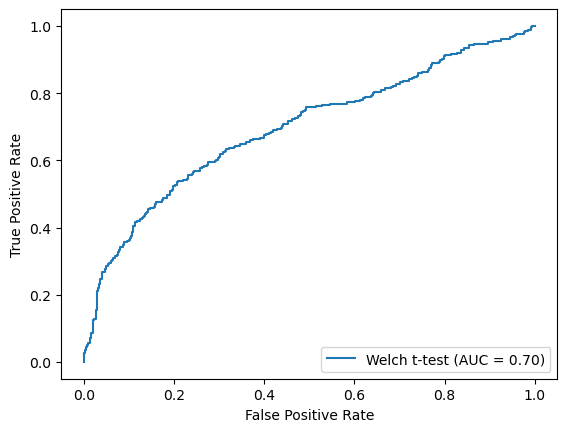

In [15]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(target_series, welch_probabilities)
roc_auc = sklearn.metrics.auc(fpr, tpr)
display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='Welch t-test')
display.plot()

# Various utility functions

In [16]:
def display_awards(scores, award_recipient):
    print("Mean accuracy:", scores['test_accuracy'].mean())
    print("Mean type 1 error:", abs(scores['test_type_1_error_ratio'].mean()))
    print("Mean ROC AUC score:", scores['test_roc_auc'].mean())
    if (abs(scores['test_type_1_error_ratio'].mean()) < 0.05 and scores['test_accuracy'].mean() > welch_accuracy):
        print(f"{award_recipient} beat the Welch t-test while maintaining a low type 1 error ratio")
    if abs(scores['test_type_1_error_ratio'].mean()) < welch_type_1_error_ratio:
        print(f"{award_recipient} beat the Welch t-test on type 1 errors")
    if (abs(scores['test_type_1_error_ratio'].mean()) < welch_type_1_error_ratio 
        and 
        scores['test_accuracy'].mean() > welch_accuracy):
        print(f"WE HAVE A WINNER!!!!\n{award_recipient} beat the Welch t-test on type 1 errors AND on accuracy")
    if scores['test_roc_auc'].mean() > welch_roc:
        print(f"{award_recipient} beat Welch on ROC AUC")

In [17]:
def measure_sklearn(model, title, columns_to_use=None):
    if columns_to_use is None:
        columns_to_use = feature_dataframe.columns
    scores = sklearn.model_selection.cross_validate(model, 
                                       feature_dataframe[columns_to_use],
                                       target_series,
                                       scoring={'accuracy': 'accuracy', 
                                                'type_1_error_ratio': type_1_error_score,
                                               'roc_auc': 'roc_auc'},
                                        cv=10
                                      )
    display_awards(scores, title)
    return scores

In [18]:
class Calibrated(BaseEstimator, TransformerMixin, ClassifierMixin):
    def __init__(self, model, maximum_type_1_error=1.0, minimum_accuracy=0.0):
        self.model = model
        self.maximum_type_1_error = maximum_type_1_error
        self.minimum_accuracy = minimum_accuracy
        self.minimum_proba = None
        self.maximum_proba = None
        self.used_threshold = None
        
    def fitted_range(self):
        return (self.minimum_proba, self.maximum_proba)
        
    def fit(self, Xs, ys):
        trainX, testX, trainY, testY = sklearn.model_selection.train_test_split(Xs, ys)
        self.model.fit(trainX, trainY)
        probs = self.model.predict_proba(testX)[:,1]
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(testY, probs)
        accuracies = []
        good_thresholds = []
        for threshold in thresholds:
            # Predicting classes based on the threshold
            predicted = (probs >= threshold)
    
            # Computing the confusion matrix
            tn, fp, fn, tp = sklearn.metrics.confusion_matrix(testY, predicted).ravel()
    
            # Calculating accuracy
            accuracy = (tp + tn) / (tp + tn + fp + fn)
            if accuracy >= self.minimum_accuracy and fp <= self.maximum_type_1_error:
                #print(f"At {threshold=}, {accuracy=} vs {self.minimum_accuracy=}\n{fp=} vs {self.maximum_type_1_error=}")
                good_thresholds.append(threshold)
        if len(good_thresholds) > 0:
            self.minimum_proba = min(good_thresholds)
            self.maximum_proba = max(good_thresholds)
            self.used_threshold = (self.minimum_proba + self.maximum_proba) / 2
        else:
            self.minimum_proba = None
            self.maximum_proba = None
            self.used_threshold = 0.5
        self.classes_ = self.model.classes_
        #self.good_thresholds = good_thresholds
        #self.thresholds = thresholds
            
    def predict(self, Xs):
        probs = self.model.predict_proba(Xs)[:,1]
        predictions = probs >= self.used_threshold
        return predictions
        
    def predict_proba(self, Xs):
        return self.model.predict_proba(Xs)
        

## Just to be stupid

Dummy gives us a baseline to be sure that the real models aren't just predicting the most common case.

Also it lets me debug failure cases.

In [19]:
dummy_scores = measure_sklearn(sklearn.dummy.DummyClassifier(strategy='most_frequent'), "Dummy")

Mean accuracy: 0.736
Mean type 1 error: 0.0
Mean ROC AUC score: 0.5
Dummy beat the Welch t-test on type 1 errors


# Greg's favourite statistical test

In [20]:
class UTest(BaseEstimator, TransformerMixin, ClassifierMixin):
    def __init__(self):
        pass
    def fit(self, X,y, weights=[]):
        pass
    def predict(self, Xs):
        answer = []
        for experiment in Xs:
            outcome = scipy.stats.mannwhitneyu(experiment.ControlValues, experiment.ExperimentValues)
            if outcome.pvalue < 0.05:
                answer.append(True)
            else:
                answer.append(False)
        return answer
    def predict_proba(self, Xs):
        answer = []
        for experiment in Xs:
            outcome = scipy.stats.ttest_ind(experiment.ControlValues, experiment.ExperimentValues, equal_var=False)
            # Is the following line correct? I think so, but maybe I should also be aware of the prior we have.
            answer.append(1-outcome.pvalue)
        return answer        

In [21]:
%%time
u = UTest()
u_answers = u.predict(experiments)
u_probabilities = u.predict_proba(experiments)
print(sklearn.metrics.confusion_matrix(create_target_series(experiments), u_answers))

[[736   0]
 [264   0]]
CPU times: user 646 ms, sys: 33.5 ms, total: 680 ms
Wall time: 304 ms


In [22]:
u_accuracy = sklearn.metrics.accuracy_score(target_series, u_answers)
u_accuracy

0.736

In [23]:
u_type_1_error_ratio = type_1_error_ratio(target_series, u_answers)
u_type_1_error_ratio

0.0

In [24]:
u_roc = sklearn.metrics.roc_auc_score(target_series, u_probabilities)
u_roc

0.6950294384057971

# Random forest using the original measurements

It seems to beat Welch if there is enough training data.

In [25]:
%%time
rfc_classic_scores = measure_sklearn(sklearn.ensemble.RandomForestClassifier(), 
                                     "Random forest using original measurements",
                                    classic_columns)

Mean accuracy: 0.825
Mean type 1 error: 0.063
Mean ROC AUC score: 0.8410780379958464
Random forest using original measurements beat Welch on ROC AUC
CPU times: user 1.23 s, sys: 10.2 ms, total: 1.24 s
Wall time: 1.24 s


# Random forest using synthesised differences

It seems to beat Welch if there is enough training data.

In [26]:
%%time
rfc_synthesised_scores = measure_sklearn(sklearn.ensemble.RandomForestClassifier(), 
                                     "Random forest using synthetic measurements",
                                    synthesised_columns)

Mean accuracy: 0.8320000000000001
Mean type 1 error: 0.05900000000000001
Mean ROC AUC score: 0.8287835385438125
Random forest using synthetic measurements beat Welch on ROC AUC
CPU times: user 1.49 s, sys: 9.68 ms, total: 1.5 s
Wall time: 1.5 s


# Dodgy calibrated RF

Maybe I was being naive, but I thought we might be able to reduce the type 1 error
if we were OK dropping the accuracy a little.

In [27]:
%%time
rfc_classic_calibrated = measure_sklearn(Calibrated(sklearn.ensemble.RandomForestClassifier(),
                                                   welch_type_1_error_ratio, welch_accuracy),
                                        "Calibrated random forest using classic measurements",
                                        classic_columns)

Mean accuracy: 0.799
Mean type 1 error: 0.039
Mean ROC AUC score: 0.8424727282603994
Calibrated random forest using classic measurements beat the Welch t-test while maintaining a low type 1 error ratio
Calibrated random forest using classic measurements beat Welch on ROC AUC
CPU times: user 1.19 s, sys: 9.29 ms, total: 1.2 s
Wall time: 1.21 s


In [28]:
%%time
cal = Calibrated(sklearn.ensemble.RandomForestClassifier(), welch_type_1_error_ratio, welch_accuracy)
cal.fit(feature_dataframe[synthesised_columns], target_series)

CPU times: user 137 ms, sys: 2.04 ms, total: 139 ms
Wall time: 139 ms


In [29]:
cal.fitted_range()

(None, None)

# Neighbour methods

In [30]:
%%time
knn_classic_scores = measure_sklearn(sklearn.neighbors.KNeighborsClassifier(), 'KNeighbours', classic_columns)

Mean accuracy: 0.8210000000000001
Mean type 1 error: 0.067
Mean ROC AUC score: 0.8060994213391472
KNeighbours beat Welch on ROC AUC
CPU times: user 37 ms, sys: 1.08 ms, total: 38.1 ms
Wall time: 37.4 ms


In [31]:
%%time
knn_synth_scores = measure_sklearn(sklearn.neighbors.KNeighborsClassifier(), 'KNeighbours', synthesised_columns)

Mean accuracy: 0.8210000000000001
Mean type 1 error: 0.067
Mean ROC AUC score: 0.8062225027978451
KNeighbours beat Welch on ROC AUC
CPU times: user 38.7 ms, sys: 1.59 ms, total: 40.3 ms
Wall time: 39.2 ms


# Neural networks

In [32]:
from tensorflow.keras import models
from tensorflow.keras import layers

from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True)

import numpy as np
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [33]:
%%time
inputs = feature_dataframe.to_numpy(dtype=float)
targets = target_series.to_numpy(dtype=float)
max_epochs = 300
hidden_size = 20
batch_size = 512
nn_scores = []
type_1_errors = []
accuracies = []
roc_scores = []
for fold, content in enumerate(kfold.split(inputs,targets)):
    train, test = content
    print("Fold", fold)

    model = models.Sequential()
    model.add(layers.Dense(hidden_size, activation='relu',input_shape=(feature_dataframe.shape[1],)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    earlystopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
    history = model.fit(inputs[train], targets[train],
                    epochs=max_epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    callbacks=[earlystopping],
                    verbose=0)
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    predictions = model.predict(inputs[test])[:,0] >= 0.5 # Predict 1 if the probability is >= 0.5
    type_1_error = type_1_error_ratio(targets[test], predictions)
    prediction_probabilies = model.predict(inputs[test])[:,0]
    roc_score = sklearn.metrics.roc_auc_score(targets[test], prediction_probabilies)
    print("After %i epochs out of %i" % (len(history.history['accuracy']), max_epochs))
    print("%s of fold %i: %f" % (model.metrics_names[0], fold, scores[0]))
    print("%s of fold %i: %f" % (model.metrics_names[1], fold, scores[1]))
    print("Type 1 error ratio of fold %i: %f" % (fold, type_1_error))
    print()
    accuracies.append(scores[1])
    type_1_errors.append(type_1_error)
    roc_scores.append(roc_score)
nn_scores = {
    'test_accuracy': numpy.array(accuracies),
    'test_type_1_error_ratio': numpy.array(type_1_errors),
    'test_roc_auc': numpy.array(roc_scores)
}
display_awards(nn_scores, f"Neural network with {hidden_size} hidden neurons")

Fold 0
Metal device set to: Apple M1


2023-09-13 21:32:45.395207: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-13 21:32:45.395298: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-09-13 21:32:45.500417: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-13 21:32:45.651416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-13 21:32:45.924289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 2ms/step


2023-09-13 21:32:47.041739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


After 39 epochs out of 300
loss of fold 0: 0.452462
accuracy of fold 0: 0.815000
Type 1 error ratio of fold 0: 0.045000

Fold 1


2023-09-13 21:32:47.274181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-13 21:32:47.500482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 1ms/step


2023-09-13 21:32:48.307624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


After 27 epochs out of 300
loss of fold 1: 0.614428
accuracy of fold 1: 0.775000
Type 1 error ratio of fold 1: 0.050000

Fold 2


2023-09-13 21:32:48.517920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-13 21:32:48.743251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 2ms/step


2023-09-13 21:32:49.539368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


After 26 epochs out of 300
loss of fold 2: 0.612346
accuracy of fold 2: 0.785000
Type 1 error ratio of fold 2: 0.045000

Fold 3


2023-09-13 21:32:49.888413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-13 21:32:50.105604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 2ms/step


2023-09-13 21:32:51.739145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


After 59 epochs out of 300
loss of fold 3: 0.437391
accuracy of fold 3: 0.845000
Type 1 error ratio of fold 3: 0.055000

Fold 4


2023-09-13 21:32:51.959747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-13 21:32:52.195244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 2ms/step
After 29 epochs out of 300
loss of fold 4: 0.516693
accuracy of fold 4: 0.800000
Type 1 error ratio of fold 4: 0.065000

Mean accuracy: 0.8040000081062317
Mean type 1 error: 0.052000000000000005
Mean ROC AUC score: 0.709531460097945
Neural network with 20 hidden neurons beat Welch on ROC AUC
CPU times: user 6.74 s, sys: 1.47 s, total: 8.22 s
Wall time: 7.72 s


2023-09-13 21:32:53.050875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Maybe I should do a calibrated version of the neural network? 

# Linear polyterms

No, you didn't see this. No good can possibly come of it.

In [34]:
import sklearn.pipeline
import sklearn.preprocessing

pipeline = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.PolynomialFeatures(include_bias=False),
    sklearn.linear_model.LogisticRegression(max_iter=100000, C=1e12)
)

In [35]:
%%time
logreg_poly_scores = measure_sklearn(pipeline, 'LinearPoly', synthesised_columns)

Mean accuracy: 0.827
Mean type 1 error: 0.043
Mean ROC AUC score: 0.8425564658441372
LinearPoly beat the Welch t-test while maintaining a low type 1 error ratio
LinearPoly beat Welch on ROC AUC
CPU times: user 1min 15s, sys: 580 ms, total: 1min 16s
Wall time: 10.1 s


In [36]:
%%time
calibrated_logreg_poly = measure_sklearn(Calibrated(pipeline,welch_type_1_error_ratio,
                                                           welch_accuracy),
                                         'Calibrated LinearPoly', synthesised_columns)

Mean accuracy: 0.8140000000000001
Mean type 1 error: 0.025
Mean ROC AUC score: 0.8266277077920913
Calibrated LinearPoly beat the Welch t-test while maintaining a low type 1 error ratio
Calibrated LinearPoly beat Welch on ROC AUC
CPU times: user 1min 4s, sys: 691 ms, total: 1min 4s
Wall time: 8.62 s


### Colouring the coefficients of the logistic regression

Particularly when we have a large number of experiments, the colours converge 
to some stunningly beautiful patterns. The 

In [37]:
%%time
pipeline.fit(feature_dataframe[synthesised_columns], target_series)

CPU times: user 10.1 s, sys: 165 ms, total: 10.3 s
Wall time: 1.38 s


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('logisticregression',
                 LogisticRegression(C=1000000000000.0, max_iter=100000))])

In [38]:
pipeline.named_steps['logisticregression'].intercept_

array([-0.1464881])

In [39]:
strengths = pandas.Series(index=pipeline.named_steps['polynomialfeatures'].get_feature_names_out(),
                          data=pipeline.named_steps['logisticregression'].coef_[0])
strengths

t_c0x0          -0.456760
t_c1x0          -1.696876
t_c2x0           3.390002
t_c3x0          -1.112604
t_c0x1          -0.178557
                   ...   
t_c1x2 t_c2x2    0.198491
t_c1x2 t_c3x2    0.317315
t_c2x2^2        -0.163905
t_c2x2 t_c3x2   -0.327167
t_c3x2^2         0.259880
Length: 90, dtype: float64

#### Cross-term stair steps

With enough data we get a strong diagonal, with echoes across the others.

<AxesSubplot: xlabel='v2', ylabel='v1'>

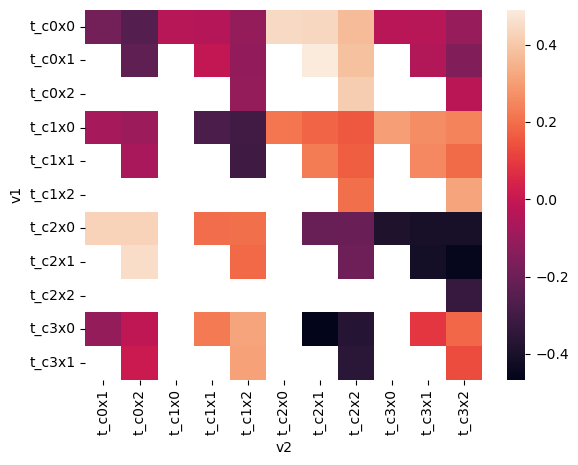

In [40]:
cross_term_strengths = strengths[strengths.index.str.contains(' ')
                                ].reset_index().rename(columns={'index': 'vars', 0: 'strength'})
cross_term_strengths['var_split'] = cross_term_strengths.vars.str.split(' ')
cross_term_strengths['v1'] = cross_term_strengths.var_split.map(lambda x: x[0])
cross_term_strengths['v2'] = cross_term_strengths.var_split.map(lambda x: x[1])
cross_term_strengths.drop('var_split', axis=1, inplace=True)
cross_term_strengths.drop('vars', axis=1, inplace=True)
cross_term_table = cross_term_strengths.pivot_table(
    index='v1',
    columns='v2',
    values='strength',
    #fill_value=0
)
import seaborn
seaborn.heatmap(cross_term_table)

#### Square terms

These are the least interesting. Even with a lot of data they don't look all that interesting.

<AxesSubplot: xlabel='experimentvar', ylabel='controlvar'>

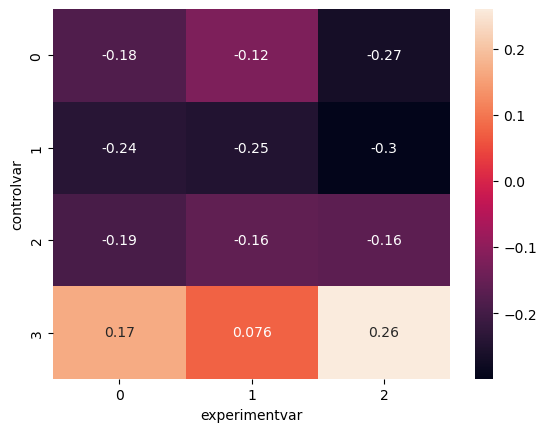

In [41]:
square_term_strengths = strengths[strengths.index.str.contains('^2', regex=False)
                                 ].reset_index().rename(columns={'index': 'varname',
                                                                0: 'strength'})
square_term_strengths['controlvar'] = square_term_strengths.varname.str.extract('t_c([0-9]+).*')
square_term_strengths['experimentvar'] = square_term_strengths.varname.str.extract('x([0-9]+)')
square_term_table = square_term_strengths.pivot_table(
    index='controlvar',
    columns='experimentvar',
    values='strength'
)
seaborn.heatmap(square_term_table, annot=True)

#### Monoterms

These are the most interesting. There are always strong bars around the middles (of both the control and
experiments), and a pleasing symmetry to them as well.

<AxesSubplot: xlabel='experimentvar', ylabel='controlvar'>

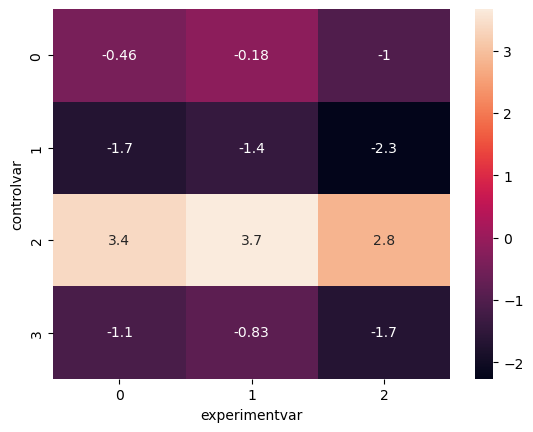

In [42]:
monoterm_strengths = strengths[~strengths.index.str.contains('^2', regex=False) & ~strengths.index.str.contains(' ')
                              ].reset_index().rename(columns={'index': 'varname',
                                                                0: 'strength'})
monoterm_strengths['controlvar'] = monoterm_strengths.varname.str.extract('t_c([0-9]+).*')
monoterm_strengths['experimentvar'] = monoterm_strengths.varname.str.extract('x([0-9]+)')
monoterm_table = monoterm_strengths.pivot_table(
    index='controlvar',
    columns='experimentvar',
    values='strength'
)
seaborn.heatmap(monoterm_table, annot=True)

<AxesSubplot: xlabel='strength', ylabel='Count'>

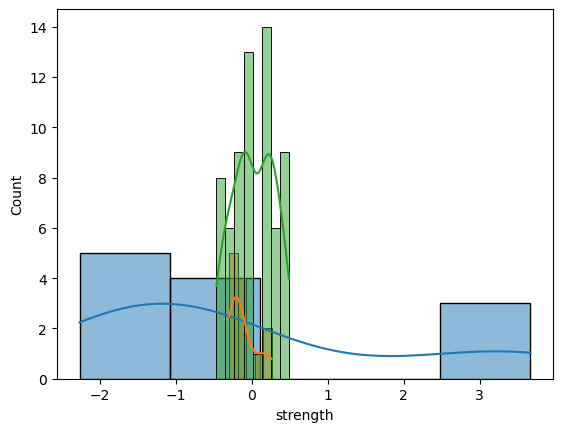

In [43]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots()
seaborn.histplot(monoterm_strengths.strength, ax=ax, kde=True, label="Mono terms")
seaborn.histplot(square_term_strengths.strength, ax=ax, kde=True, label="Square terms")
seaborn.histplot(cross_term_strengths.strength, ax=ax, kde=True, label="Cross terms")

#monoterm_strengths.plot.hist(ax=ax)